# Assignment 2: Classification
# Using Machine Learning Tools CS3317

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

## 1. Investigate Dataset (10% = 3 marks)

In [2]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset [0.5 marks]
Do this from the csv file, `assignment2.csv`, as done in assignment 1 and workshops 2 and 3. Extract the feature names and label names for use later on.  Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [6]:
# Your code here
data = pd.read_csv("/Users/malujie/Machine-learning/A2/assignment2.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

In [27]:
data.head()

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,malignant,15.494654,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,19.522957,22.427276,135.128520,1286.903131,0.142725,0.407483,0.445992,0.171662,0.353211,0.097731
1,malignant,16.229871,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,19.140235,24.905156,123.886045,1234.499997,0.129135,0.223918,0.248846,0.136735,0.284427,0.085758
2,malignant,16.345671,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,19.144816,25.601433,125.113036,1202.749973,0.135017,0.314402,0.332505,0.161497,0.313038,0.084340
3,malignant,13.001009,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,15.565911,26.145119,102.958265,737.655082,0.161390,0.485912,0.430007,0.167254,0.432297,0.117705
4,malignant,16.416060,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,18.620376,22.306233,124.002529,1139.490971,0.133950,0.230996,0.316620,0.131715,0.269591,0.080497


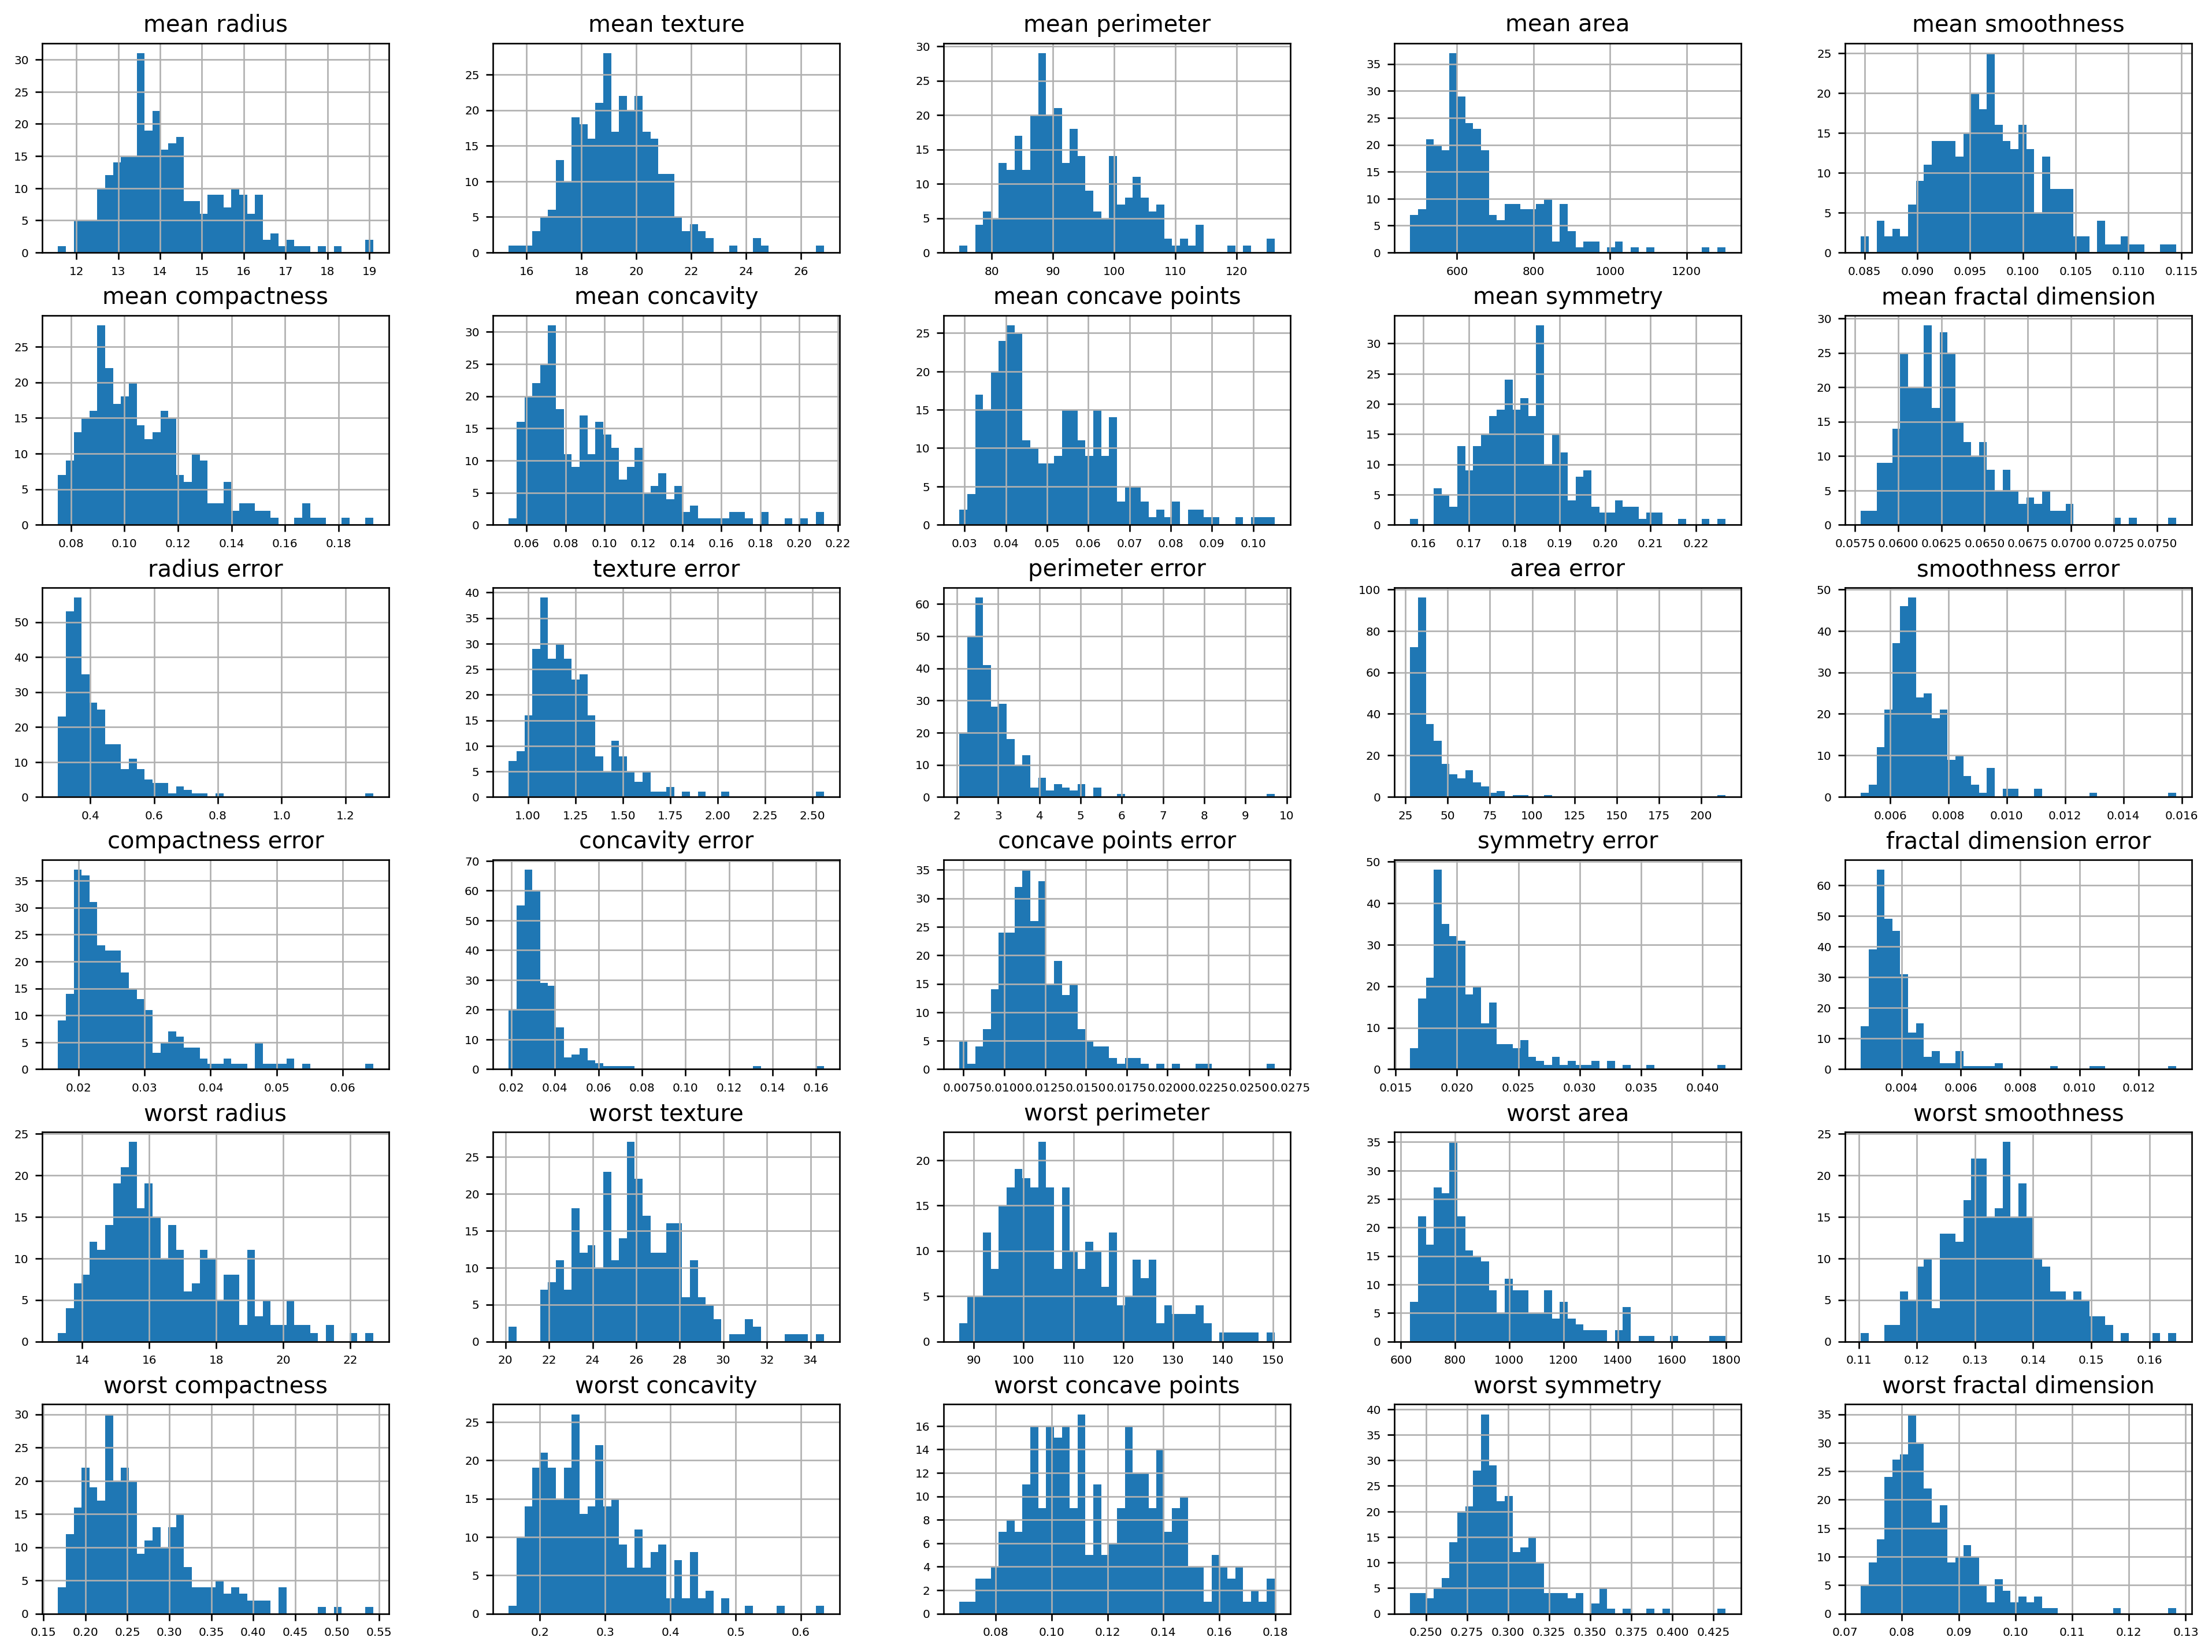

In [26]:
dummmy = data.hist(bins=40, figsize=(20,15))

### 1.2 Visualise the dataset [1.5 marks]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - **display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot** (see example plot below and a code fragment to help you) - and note that your plot does not need to look exactly the example here;
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

<center><img src="Example_Hist_Plot.png" width="300" alt="Example plot of histogram"></center>

In [ ]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
fig, axes = plt.subplots(Nrows, Ncols, figsize=(20, 15))
...
sns.histplot(data=data, x=??, hue="??", bins=??, kde=True, ax=axes[row,col], edgecolor=None)

<AxesSubplot:xlabel='worst fractal dimension', ylabel='Count'>

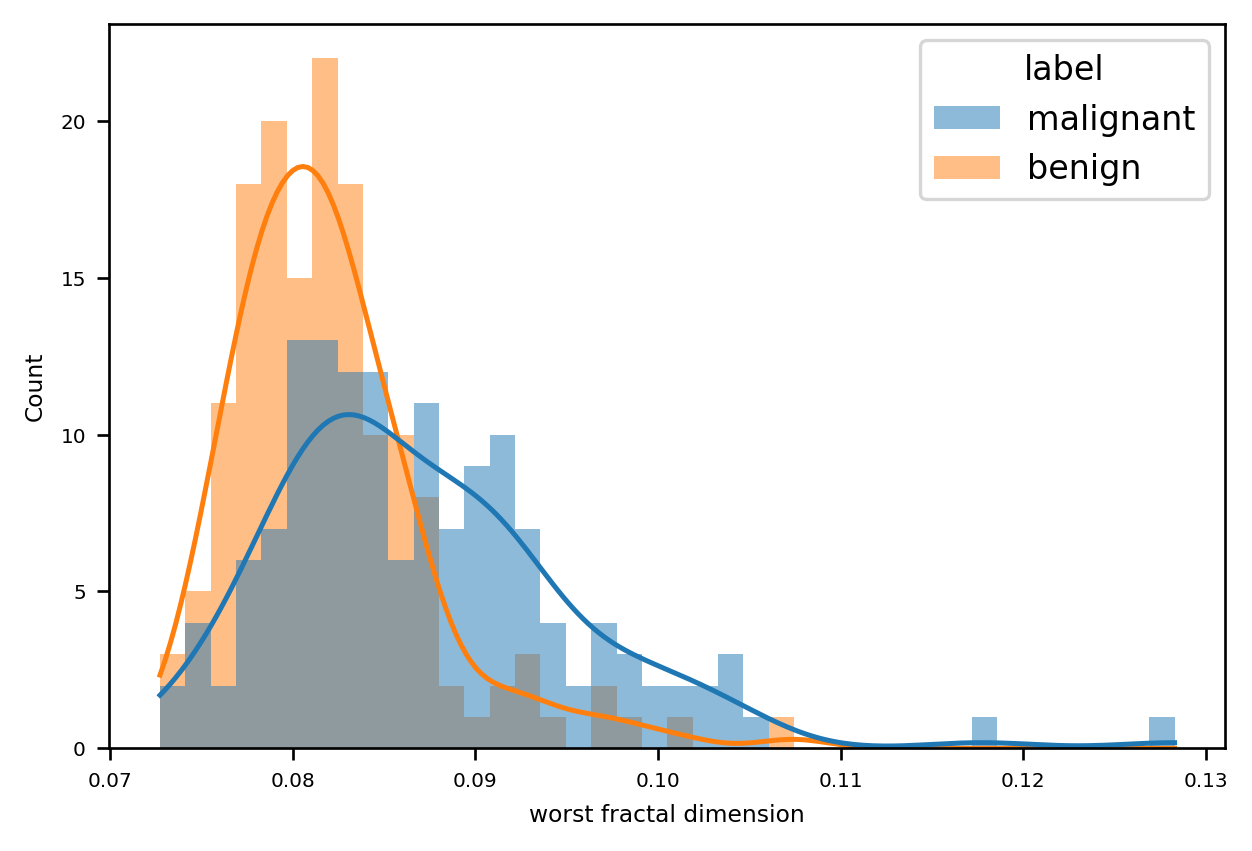

In [42]:
# Your code here
sns.histplot(data=data, x="worst fractal dimension", hue="label", bins=40, kde=True, edgecolor=None)

### 1.3 Ranking the features [0.5 marks]

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

In [4]:
# Your answer here
# 

### 1.4 Splitting the dataset [0.5 marks]

Split the dataset into appropriate subsets. You must choose what the subsets are and how big they are. However, we want to make sure the proportion of the two classes is consistent across all datasets, so use the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [4]:
# Your code here

## 2. Build, Train and Optimise Classifiers (60% = 18 marks)

### 2.1 Pipeline [0.5 marks]
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [4]:
# Your code here

### 2.2 Baseline measurements [1.5 marks]

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Code is given below for the latter metrics (all metrics are discussed in lecture 4 and many are in workshop 4).

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers (as in workshop 4). 

In [5]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

In [4]:
# Your code here

### 2.3 Choose a performance metric [0.5 marks]

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.  **Give a reason for your choice.**

In [7]:
# Your answer here

### 2.4 SGD baseline [1 mark]

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier (as seen in workshop 5). For this baseline case use the default settings for all the hyperparameters.

In [4]:
# Your code here

### 2.5 Confusion matrix [1 mark]

Calculate and display the normalized version of the confusion matrix.  From this **calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

In [4]:
# Your code here

In [6]:
# Your answer here

### 2.6 Main classifier [11 marks]

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sci-kit learn functions in sklearn.model_selection.cross* and anything used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions).

**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [4]:
# Your code here

In [4]:
# Your answer here

### 2.7 Model selection [1 mark]

**Choose the best classifier** (as seen in workshops 3 to 6) and give details of your hyperparameter settings. **Explain the reason for your choice.**

In [4]:
# Your answer here

### 2.8 Final performance [1.5 marks]

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

In [4]:
# Your code here

In [4]:
# Your answers here

## 3. Decision Boundaries (15% = 4.5 marks)

### 3.1 Rank features [1 mark]

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [4]:
# Your code here

### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help (taken from workshop 6).

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following: 0.5*(mean(x1) + mean(x2)), where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [ ]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [ ]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of mean values (to populate constant features with)
    n1, n2: index numbers of features that change (for xx and yy)
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [ ]:
# Your code here

### 3.3 Interpretation [1 mark]

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

In [3]:
# Your answer here

## 4. Second Round (15% = 4.5 marks)

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



### 4.1 New estimate [3.5 marks]

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

In [4]:
# Your code here

### 4.2 Performance difference [1 mark]

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

In [4]:
# Your answer here